<a href="https://colab.research.google.com/github/ngarciap/AnalisisExploratorioDeDatos/blob/main/Exploraci%C3%B3n_y_limpieza_de_archivos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cargue de archivos de Rxs del Mercado Farmacéutico Colombiano**
***Preparación y Cargue de un Dataset / Asociado a mi pregunta SMART***

In [1]:
# Importar librerias
import pandas as pd
import numpy as np
import os

# Matplotlib y  seaborn para gráficos
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['figure.dpi'] = 200

#from google.colab import drive

# Cargar Dataframes desde Google Drive
drive.mount('/content/drive', force_remount=True)
df_producto = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_PRODUTO.TXT', sep='	', encoding='latin1', dtype=str)
df_laboratorio = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_LABORATORIO.TXT', sep='	', encoding='latin1', dtype=str)
df_prescripciones = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/CUP_FATO.TXT', sep='	', encoding='latin1', dtype=str)
df_category = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Analisis Exploratorio de Datos/Bases/Market COL Jun/Category.xlsx', engine='openpyxl', dtype=str)
"""
# Cargar Dataframes desde máquina local
df_producto = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_PRODUTO.TXT"), sep='	', encoding='latin1', dtype=str)
df_laboratorio = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_LABORATORIO.TXT"), sep='	', encoding='latin1', dtype=str)
df_prescripciones = pd.read_csv(os.path.join(os.getcwd() + "\Bases", "CUP_FATO.TXT"), sep='	', encoding='latin1', dtype=str)
df_category = pd.read_excel(os.path.join(os.getcwd() + "\Bases", "Category.xlsx"), engine='openpyxl', dtype=str) """

**Se procede a Cruzar la Tabla principal de Rx con Productos y Laboratorios para poder obtener un Dataframe que me inidque prescripciones por laboratorio de todo el Dataset, adicional se filtran y se alista el dataframe para estudiarlo mejor**

In [2]:
# Alistamiento de tabla de productos para traer el Laboratorio y cruzar con los articulos claisificados corporativamente
df_producto_completo = pd.merge(df_producto, df_laboratorio, how='inner', left_on='PRO_LAB_ID', right_on='LAB_ID')
df_producto_completo = pd.merge(df_producto_completo, df_category, how = 'inner', on='PRO_ID')

col_descriptivas = df_prescripciones.columns[:df_prescripciones.columns.get_loc('ESP_ID') + 1].tolist()
col_meses = df_prescripciones.columns[df_prescripciones.columns.get_loc('ESP_ID') + 1:].tolist()
df_prescripciones[col_meses] = df_prescripciones[col_meses].astype(int)

df_prescripciones = df_prescripciones.groupby(col_descriptivas)[col_meses].sum().reset_index()
df_prescripciones = pd.melt(df_prescripciones, id_vars=col_descriptivas, var_name='PERIODO', value_name='VALOR')
df_prescripciones = df_prescripciones[df_prescripciones['VALOR'] != 0]

# Cruce de Prescrupciones con Producto y filtrado de Columnas de interés
df_prescripciones = pd.merge(df_prescripciones, df_producto_completo, how='inner', on='PRO_ID')
df_prescripciones_agrupado = df_prescripciones.groupby(['LAB_DESC', 'PERIODO'])['VALOR'].sum().reset_index()

# Se filtra el último mes de la base para analizarlo
df_prescripciones_agrupado = df_prescripciones_agrupado[df_prescripciones_agrupado['PERIODO'] == 'MES59']

**Se realiza análisis sobre el Dataframe que contiene las prescripciones por laboratorio**

In [6]:
df_prescripciones_agrupado.shape

(420, 3)

El dataframe indica que en un periodo de 5 años, se tienen 420 laboratorios de los cuales mínimo 1 prescripción en ese periodo de tiempo

In [7]:
df_prescripciones_agrupado.describe()

,VALOR
count,420.000000
mean,1398.983333
std,6593.062438
min,1.000000
25%,7.000000
50%,40.500000
75%,427.250000
max,112820.000000


El promedio de las Prescripciones por laboratorio en el último periodo es de 1399 prescripciones
Con un mínimo de 1 prescripción y un máximo de 112.820.

In [8]:
df_prescripciones_agrupado.dtypes

LAB_DESC    object
PERIODO     object
VALOR        int64
dtype: object

La columna a analizar es el valor de Rx el cual está especificado por Laboratorio y por Periodo, aunque en este caso se filtró solo el último periodo

In [9]:
print(df_prescripciones_agrupado.groupby('LAB_DESC')['VALOR'].sum().sort_values(ascending=False) / df_prescripciones_agrupado['VALOR'].sum() * 100)

LAB_DESC
LAB NO INDICADO      19.201018
TECNOQUIMICAS         6.673554
MCKESSON              5.229308
NOVAMED               4.577644
PROCAPS               3.952530
                       ...    
ERON                  0.000170
BIOTEFAR              0.000170
BLAU FARMACEUTICA     0.000170
ROCIPHAR              0.000170
SERES                 0.000170
Name: VALOR, Length: 420, dtype: float64


Se observa que el 19,2% de la muestra no tiene un laboratorio indicado, y seguido va el laboratorio Tecnoquimicas y MK los cuales pertenecen al mismo grupo

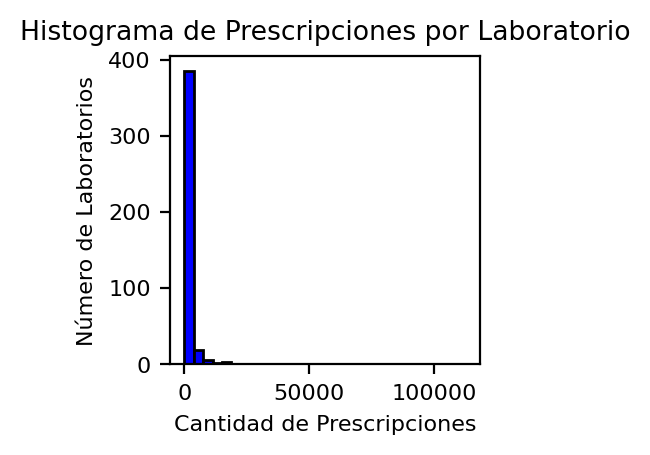

In [19]:
# Creación de Histograma

plt.hist(df_prescripciones_agrupado['VALOR'], bins=30, color='blue', edgecolor='black')
plt.title('Histograma de Prescripciones por Laboratorio')
plt.xlabel('Cantidad de Prescripciones')
plt.ylabel('Número de Laboratorios')
plt.show()

Del Histograma se observa que existe una alta variación en los datos y su distribución es atípica, ya que son muy pocos los laboratorios con unas Rx de unas magnitudes tan altas de Rx, y la gran matoria se concentra en valores cercanos a cero.